In [1]:
from __future__ import print_function

import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import json
import os
import copy
import time
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("/Users/admin/work")
import my_utils

In [2]:
input_list = ['MMM', 'T', 'ABBV', 'ABT', 'ACN', 'AGN', 'ALL', 'GOOGL', 
              'GOOG', 'MO', 'AMZN', 'AXP', 'AIG', 'AMGN', 'AAPL', 'BAC', 'BIIB', 
              'BLK', 'BA', 'BMY', 'CVS', 'COF', 'CAT', 'CELG', 'CVX', 'CSCO', 'C', 
              'KO', 'CL', 'CMCSA', 'COP', 'COST', 'DHR', 'DOW', 'DUK', 'DD', 'EMC', 
              'EMR', 'EXC', 'XOM', 'FB', 'FDX', 'F', 'GD', 'GE', 'GM', 'GILD', 'GS', 'HAL', 
              'HD', 'HON', 'INTC', 'IBM', 'JPM', 'JNJ', 'KMI', 'LLY', 'LMT', 'LOW', 'MA', 
              'MCD', 'MDT', 'MRK', 'MET', 'MSFT', 'MDLZ', 'MON', 'MS', 'NKE', 'OXY', 
              'ORCL', 'PEP', 'PFE', 'PM', 'PG', 'QCOM', 'RTN', 'SLB', 'SPG', 'SO', 'SBUX', 
              'TGT', 'TXN', 'BK', 'PCLN', 'TWX', 'FOXA', 'FOX', 'USB', 'UNP', 'UPS', 'UTX', 
              'UNH', 'VZ', 'V', 'WMT', 'WBA', 'DIS', 'WFC']

In [3]:
print ("Started!!")

st = time.time()
start_date="2015-04-01"
end_date="2016-04-01"
input_data, date, input_list = my_utils.get_fixed_data(input_list, start_date=start_date, end_date=end_date) 
elapsed = time.time() - st
print ("time for getting data:", elapsed)

Started!!
fail_name_list:  []


IndexError: list index out of range

In [3]:
import time
print ("Start!!")

st = time.time()
start_date="2014-06-01"
end_date="2016-06-01"
input_data, date, input_list = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
sp = quandl.get("YAHOO/INDEX_OEX", start_date=start_date, end_date=end_date)
target_data = np.array(sp['Open'])
elapsed = time.time() - st
print ("time for getting training_data:", elapsed)

Start!!
fail_name_list:  []
time for getting training_data: 463.227899075


In [4]:
target_data = np.atleast_2d(target_data).T
print (target_data.shape)
print (input_data.shape)

(505, 1)
(505, 94)


I suceeded to fetch almost all of data(94/100) used for S&P100.

In [138]:
import pandas as pd

date_ = pd.to_datetime(date[0])
input_ = pd.DataFrame(input_data[:, :20], index=date)
# input_ = pd.DataFrame(input_data, index=date)
target_ = pd.DataFrame(target_data, index=date_)

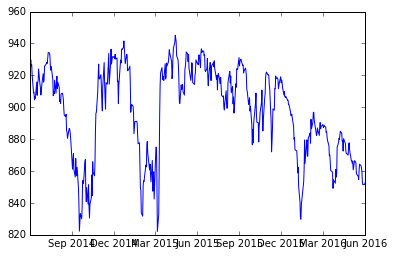

In [58]:
plt.plot(target_)

In [88]:
class SearchConfig:
    history_length=[8, 64]
    learning_rate=[1e-3, 10]
    leraning_anneal=[3.0e2, 3.0e4]
    n_feature=[18, 1024]
    n_filter=[2, 8]
    n_hidden=[18, 1024]

In [89]:
import numpy as np

def sample_geo(conf):
    low = conf[0]
    high = conf[1]
    u = np.random.uniform()
    return np.exp((np.log(high / low) * u + np.log(low)))

In [90]:
def make_train(data, hl):
    return np.array([data[i:i+hl] for i in xrange(len(data) - hl + 1)])

In [110]:
input_.shape

(505, 20)

# Mutli Scale CNN

In [ ]:
class MSCNN(object):
    """using multisclae CNN, duplicate indicator"""

    def __init__(self):
        self.activation = config.activation
        self.history_length = config.history_length
        # the nubmer of stocks to use for duplicating 
        self.n_stock = config.n_stock
        # scale of the number of features
        self.n_feature = config.n_feature
        self.n_down = config.n_down
        self.n_smooth = config.n_smooth
        self.k_w = config.k_w
        self.n_hidden = config.n_hidden
        self.n_batch = config.n_batch
        self.n_epoch = config.n_epoch
        self.learning_rate = config.learning_rate
        # automatically choose device 
        sess_conf = tf.ConfigProto(allow_soft_placement=True)
        self.sess = tf.Session(config=sess_conf)
        # the actual dimention of input
        self.n_input = (1 + self.n_smooth + self.n_down) * self.n_stock
        # the length of the data as input
        self.n_history = max(self.n_smooth + self.history_length - 1, self.n_down * self.history_length)
        print ("building model....")
        with self.sess.as_default():
            self.build_model()
        print('finished!')
        
def build_train(self):
        K.set_learning_phase(1)
        # just for conveninece of trainig, seprate placehoder for critic and target network
        # critic network input  should be [raw_data, smoothed, downsampled, action]
        self.model = self.build_model()
        # actor network input should be [raw_data, smoothed, downsampled]
        self.actor = self.build_actor()
        self.actor_target = self.build_actor()
        # transform input into the several scales and smoothing
        self.state =  tf.placeholder(tf.float32, [None, self.n_history, self.n_stock], name='state')
        self.state_target = tf.placeholder(tf.float32, [None, self.n_history, self.n_stock], name='state_target')
        # reshape to convolutional input
        state_ = tf.reshape(self.state, [-1, self.n_history, self.n_stock, 1])
        state_target_ = tf.reshape(self.state_target, [-1, self.n_history, self.n_stock, 1])
        converted_state = self.transform_input(state_)
        converted_state_target = self.transform_input(state_target_)
        
        # build graph for citic training
        self.action = tf.placeholder(tf.float32, [None, self.n_stock])
        self.Q = tf.squeeze(self.critic(converted_state + [self.action,]))
        # target network
        self.actor_target_output = self.actor(converted_state_target)
        Q_target = tf.squeeze(self.critic_target(converted_state_target + [self.actor_target_output, ]))
        self.reward = tf.placeholder(tf.float32, [None], name='reward')
        target = self.reward  + self.gamma * Q_target
        # optimization
        self.learning_rate = tf.placeholder(tf.float32, shape=[], name="learning_rate")
        self.loss = tf.reduce_mean(tf.square(target - self.Q), name='loss')
        self.critic_optim = tf.train.AdamOptimizer(self.learning_rate) \
            .minimize(self.loss, var_list=self.critic.trainable_weights)
        
        # build graph for actor training
        self.actor_output = self.actor(converted_state)
        self.Q_actor = tf.squeeze(self.critic(converted_state + [self.actor_output,]))
        # optimization
        self.actor_optim = tf.train.AdamOptimizer(self.learning_rate) \
            .minimize(-self.Q_actor, var_list=self.actor.trainable_weights)
        
        # initialize network
        tf.initialize_all_variables().run(session=self.sess)
        weights = self.critic.get_weights()
        self.critic_target.set_weights(weights)
        weights = self.actor.get_weights()
        self.actor_target.set_weights(weights)
    
    def build_model(self):
        K.set_learning_phase(1)
        # recieve convereted tensor: raw_data, smooted_data, and downsampled_data
        nf = self.n_feature
        # layer1
        # smoothed input
        sm_model = [Sequential() for _ in range(self.n_smooth - 1)]
        for m in sm_model:
            m.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same', input_shape=(self.history_length, self.n_stock, 1)))
            m.add(BatchNormalization(mode=2, axis=-1))
            m.add(PReLU())
        # down sampled input
        dw_model = [Sequential() for _ in range(self.n_down - 1)]
        for m in dw_model:
            m.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same', input_shape=(self.history_length, self.n_stock, 1)))
            m.add(BatchNormalization(mode=2, axis=-1))
            m.add(PReLU())
        # raw input
        state = Sequential()
        state.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same', input_shape=(self.history_length, self.n_stock, 1)))
        state.add(BatchNormalization(mode=2, axis=-1))
        state.add(PReLU())
        state.build()
        merged = Merge([state,] + sm_model + dw_model, mode='concat')
        # layer2
        nf = nf * 2
        model = Sequential()
        model.add(merged)
        model.add(SpatialDropout2D(0.5))
        model.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
        model.add(BatchNormalization(mode=2 , axis=-1))
        model.add(PReLU())
        model.add(Flatten())
        # layer3
        model.add(Dense(self.n_hidden))
        model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # layer4
        model.add(Dropout(0.5))
        model.add(Dense(int(np.sqrt(self.n_hidden))))
        model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # output
        model.add(Dropout(0.5))
        model.add(Dense(1))
        return model
    
    def transform_input(self, input):
        # the last data is the newest information
        raw = input[:, self.n_history - self.history_length:, :, :]
        # smooth data
        smoothed = []
        for n_sm in range(2, self.n_smooth + 1):
            smoothed.append(
                tf.reduce_mean(tf.pack([input[:, self.n_history - st - self.history_length:self.n_history - st, :, :] for st in range(n_sm)]),0)
            )
        # downsample data
        down = []
        for n_dw in range(2, self.n_down + 1):
            sampled_ = tf.pack([input[:, idx, :, :] for idx in range(self.n_history - n_dw * (self.history_length - 1) - 1, self.n_history, n_dw)])
            down.append(tf.transpose(sampled_, [1, 0, 2, 3]))
        return [raw,] +  smoothed + down

# CNN

Epoch 1/100
244/244 [==============================] - 1s - loss: 3480326.1611     
Epoch 2/100
244/244 [==============================] - 1s - loss: 20716.6102     
Epoch 3/100
244/244 [==============================] - 1s - loss: 9686.0586     
Epoch 4/100
244/244 [==============================] - 1s - loss: 3544.1705     
Epoch 5/100
244/244 [==============================] - 1s - loss: 3400.0593     
Epoch 6/100
244/244 [==============================] - 1s - loss: 3040.4271     
Epoch 7/100
244/244 [==============================] - 1s - loss: 824.5483     
Epoch 8/100
244/244 [==============================] - 1s - loss: 581.4903     
Epoch 9/100
244/244 [==============================] - 1s - loss: 398.6596     
Epoch 10/100
244/244 [==============================] - 1s - loss: 752.8089     
Epoch 11/100
244/244 [==============================] - 1s - loss: 393.9079     
Epoch 12/100
244/244 [==============================] - 1s - loss: 254.8980     
Epoch 13/100
244/244 [=====

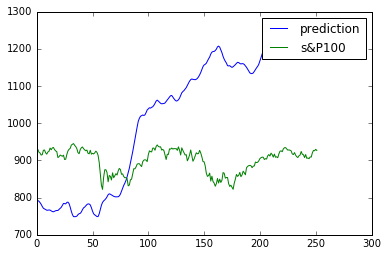

In [139]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, SpatialDropout2D
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
import tensorflow as tf
from keras import backend as K

K.set_learning_phase(0)
n_stock = input_.shape[1]
# random search
sess = tf.Session()
conf = SearchConfig()
for _ in xrange(1):
    tf.reset_default_graph()
    sess = tf.Session()
    K.set_session(sess)
    model = Sequential()
    hl = int(sample_geo(conf.history_length))
    hl = 10
    # layer1
    k_w, n_feature = int(sample_geo(conf.n_filter)), int(sample_geo(conf.n_feature)) 
    n_feawture=500
    model.add(Convolution2D(nb_filter=n_feature, nb_row=k_w, nb_col=1, border_mode='same', input_shape=(hl, n_stock, 1)))
    model.add(BatchNormalization(mode=0, axis=-1))
    model.add(PReLU())
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # layer2
    k_w, n_feature = int(sample_geo(conf.n_filter)), int(sample_geo(conf.n_feature)) 
    n_feature=1000
    model.add(SpatialDropout2D(0.5))
    model.add(Convolution2D(nb_filter=n_feature, nb_row=k_w, nb_col=1, border_mode='same'))
    # model.add(BatchNormalization(mode=0, axis=-1))
    model.add(PReLU())
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    
    k_w, n_feature = int(sample_geo(conf.n_filter)), int(sample_geo(conf.n_feature)) 
    n_feature=1000
    model.add(SpatialDropout2D(0.5))
    model.add(Convolution2D(nb_filter=n_feature, nb_row=k_w, nb_col=1, border_mode='same'))
    # model.add(BatchNormalization(mode=0, axis=-1))
    model.add(PReLU())
    model.add(Flatten())

    # layer4
    # n_hidden = int(sample_geo(conf.n_hidden))
    n_hidden = 20
    model.add(Dropout(0.5))
    model.add(Dense(n_hidden))
    # model.add(BatchNormalization(mode=1, axis=-1))
    model.add(PReLU())
    # output
    model.add(Dropout(0.5))
    model.add(Dense(1))
        
    lr = sample_geo(conf.learning_rate)
    lr=1e-2
    adm = Adam(lr=lr)
    model.compile(optimizer=adm, loss='mse')
    
    # test_data = make_data(target_data, hl)
    X = make_data(input_.values, hl)
    X = X.reshape(X.shape + (1,))
    Y = target_.values
    test_idx = list(target_.index).index(pd.Timestamp('2015-06-01'))
    train_ = train_data.reshape(train_data.shape + (1,))
    train_X = X[:test_idx - hl + 1]
    test_X = X[test_idx - hl + 1:]
    train_Y = Y[hl-1:test_idx]
    test_Y = Y[test_idx:]
    # training
    model.fit(train_X, train_Y, nb_epoch=100, batch_size=32)
    
    output = model.predict(test_X)

    plt.plot(output, label='prediction')
    plt.plot(test_Y, label='s&P100')
    plt.legend()
    

# MLP

Epoch 1/500
253/253 [==============================] - 0s - loss: 312.0874     
Epoch 2/500
253/253 [==============================] - 0s - loss: 2.0276     
Epoch 3/500
253/253 [==============================] - 0s - loss: 0.4391     
Epoch 4/500
253/253 [==============================] - 0s - loss: 0.3307     
Epoch 5/500
253/253 [==============================] - 0s - loss: 0.1863     
Epoch 6/500
253/253 [==============================] - 0s - loss: 0.0792     
Epoch 7/500
253/253 [==============================] - 0s - loss: 0.0749     
Epoch 8/500
253/253 [==============================] - 0s - loss: 0.0684     
Epoch 9/500
253/253 [==============================] - 0s - loss: 0.0634     
Epoch 10/500
253/253 [==============================] - 0s - loss: 0.0873     
Epoch 11/500
253/253 [==============================] - 0s - loss: 0.1400     
Epoch 12/500
253/253 [==============================] - 0s - loss: 0.1356     
Epoch 13/500
253/253 [==============================] - 0s 

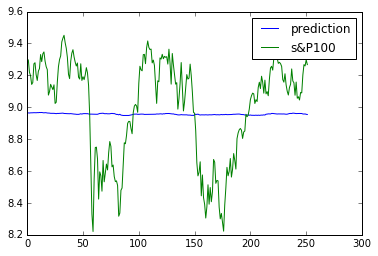

In [131]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, SpatialDropout2D
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
import tensorflow as tf
from keras import backend as K

K.set_learning_phase(0)
n_stock = input_.shape[1]
# random search
sess = tf.Session()
conf = SearchConfig()
for _ in xrange(1):
    tf.reset_default_graph()
    sess = tf.Session()
    K.set_session(sess)
    model = Sequential()
    # layer1
    n_hidden = int(sample_geo(conf.n_hidden))
    model.add(Dense(n_hidden, input_dim=n_stock))
    model.add(BatchNormalization(mode=1))
    model.add(PReLU())
    # layer2
    n_hidden = int(sample_geo(conf.n_hidden))
    model.add(Dropout(0.5))
    model.add(Dense(n_hidden))
    model.add(BatchNormalization(mode=1))
    model.add(PReLU())
    
    # layer3
    # n_hidden = int(sample_geo(conf.n_hidden))
    n_hidden = int(sample_geo(conf.n_hidden))
    model.add(Dropout(0.5))
    model.add(Dense(n_hidden))
    # model.add(BatchNormalization(mode=1, axis=-1))
    model.add(PReLU())
    # layer4
    # n_hidden = int(sample_geo(conf.n_hidden))
    n_hidden = int(sample_geo(conf.n_hidden))
    model.add(Dropout(0.5))
    model.add(Dense(n_hidden))
    # model.add(BatchNormalization(mode=1, axis=-1))
    model.add(PReLU())
    # output
    model.add(Dropout(0.5))
    model.add(Dense(1))
        
    lr = sample_geo(conf.learning_rate)
    lr=1e-2
    adm = Adam(lr=lr)
    model.compile(optimizer=adm, loss='mse')
    
    # test_data = make_data(target_data, hl)
    X = input_.values
    Y = target_.values /100
    test_idx = list(target_.index).index(pd.Timestamp('2015-06-01'))
    train_ = train_data.reshape(train_data.shape + (1,))
    train_X = X[:test_idx]
    test_X = X[test_idx:]
    train_Y = Y[:test_idx]
    test_Y = Y[test_idx:]
    # training
    model.fit(train_X, train_Y, nb_epoch=500, batch_size=32)
    
    output = model.predict(test_X)

    plt.plot(output, label='prediction')
    plt.plot(test_Y, label='s&P100')
    plt.legend()
    

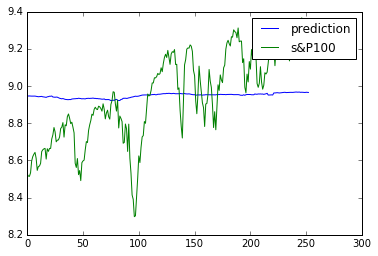

In [133]:
output = model.predict(train_X)

plt.plot(output, label='prediction')
plt.plot(train_Y, label='s&P100')
plt.legend()

# Multi Scale

In [ ]:
uild_critic(self):
        K.set_learning_phase(0)
        # recieve convereted tensor: raw_data, smooted_data, and downsampled_data
        nf = self.n_feature
        # smoothed input
        sm_model = [Sequential() for _ in range(self.n_smooth - 1)]
        for m in sm_model:
            m.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same', input_shape=(self.history_length, self.n_stock, 1)))
            m.add(BatchNormalization(mode=2, axis=-1))
            m.add(PReLU())
        # down sampled input
        dw_model = [Sequential() for _ in range(self.n_down - 1)]
        for m in dw_model:
            m.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same', input_shape=(self.history_length, self.n_stock, 1)))
            m.add(BatchNormalization(mode=2, axis=-1))
            m.add(PReLU())
        # raw input
        state = Sequential()
        # layer1
        nf = self.n_feature
        state.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same', input_shape=(self.history_length, self.n_stock, 1)))
        state.add(BatchNormalization(mode=2, axis=-1))
        state.add(PReLU())
        merged = Merge([state,] + sm_model + dw_model, mode='concat', concat_axis=-1)
        # layer2
        nf = nf * 2
        merged_state = Sequential()
        merged_state.add(merged)
        # model.add(SpatialDropout2D(0.5))
        merged_state.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
        merged_state.add(BatchNormalization(mode=2, axis=-1))
        merged_state.add(PReLU())
        merged_state.add(Flatten())
        # layer3
        action = Sequential()
        action.add(Lambda(lambda x: x, input_shape=(self.n_stock,)))
        action.add(BatchNormalization(mode=1, axis=-1))
        merged = Merge([merged_state, action], mode='concat')
        model = Sequential()
        model.add(merged)
        model.add(Dense(self.n_hidden))
        model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # layer4
        # model.add(Dropout(0.5))
        model.add(Dense(int(np.sqrt(self.n_hidden))))
        # model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # output
        # model.add(Dropout(0.5))
        model.add(Dense(1))
        return model